<a href="https://colab.research.google.com/github/tanner-k/ECON488_Project/blob/main/DD_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the libraries needed to do the analysis for the project.
import pandas as pd
import numpy as np

# Import linearmodels library to do the two-way fixed effects regression.
while True:
  try:
    from linearmodels import PanelOLS
    break
  except ModuleNotFoundError:
    !pip install linearmodels

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare the Data
The next several cells of code prepare the data for our Differences in Differences analysis. The data starts as a running total of COVID-19 cases and deaths. This data is also set up as state by day data, whereas we need it the data to be set up in state by week data. 

In [2]:
# Read in the data for the project.
data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [3]:
# Create a variable for the list of states we want to include in our analysis. 
included_states = ['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'West Virginia']

In [4]:
# Keep only the states we want to include in our analysis.
data = data.loc[data.state.isin(included_states)]

# Organize the data by state and by date.
data = data.sort_values(by=['state', 'date'],ascending=[True, True])

In [5]:
# Create daily counts of cases and deaths.
data['daily_cases'] = data.groupby(by='state')['cases'].diff().fillna(0)
data['daily_deaths'] = data.groupby(by='state')['deaths'].diff().fillna(0)

# Eliminate negative values from transitioning from state to state.
data[data['daily_cases'] < 0] = 0
data[data['daily_deaths'] < 0] = 0

In [6]:
# Create a week variable.
data['date'] = pd.to_datetime(data['date'])
data['week_of_year'] = data.date.dt.strftime('%U').astype('int32')

In [7]:
# Collapse the data into counts per week.
cases = data.groupby(['state', 'week_of_year'])['daily_cases','daily_deaths'].sum()
cases = pd.DataFrame(data=cases)
cases = cases.rename(columns={'daily_cases': 'weekly_cases', 'daily_deaths': 'weekly_deaths'})
cases = cases.reset_index(level=['state', 'week_of_year'])
cases = cases.drop(axis=0, index=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


This is still part of the data preparation process, but we created a csv file of the week that the mask mandate went into effect for each state. This is a dummy variable that we have to put into the same Pandas DataFrame for our regression. 

In [8]:
# Import mask mandate data.
mask = pd.read_csv('https://raw.githubusercontent.com/tanner-k/DD-COVID19/master/Mask_Mandate_Data.csv')

In [9]:
# Make the mask data have the same columns as the case data.
mask = mask.rename(columns={'State': 'state', 'Week Number': 'week_of_year', 'Mask Mandate': 'mask_mandate'})
mask['weeks'] = mask.week_of_year
mask['State'] = mask.state

In [10]:
# Set the index for the mask and cases dataframes and then combine them.
mask = mask.set_index(['state', 'week_of_year'])
cases = cases.set_index(['state', 'week_of_year'])
cases = cases.combine_first(mask)

We need to make a variable for weeks where the mask mandate is in effect. This is the independent variable that will be used for the first regression. 

We also need to create a variable for the weeks before and after the mandate for our second regression. This variable will be used to create dummy variables that will be used in the regression. 


In [11]:
# Here we create a mandate week variable that will be used to help create both a variable for the weeks where the mandate 
# is in effect and a variable for the weeks before and after the mandate variable. 
cases['mandate_week'] = 0
cases.loc[cases.mask_mandate==1, 'mandate_week'] = cases.loc[cases.mask_mandate==1, 'weeks']

for states, week in cases.groupby(level=0):
  cases.loc[cases.State==states, 'mandate_week'] = week.mandate_week.max()
cases = cases.dropna()

In [12]:
# The mandate variable is for weeks where the mask mandate is in effect.
cases['mandate'] = 0
cases.loc[cases.weeks>=cases.mandate_week, 'mandate'] = 1
cases.loc[cases.mandate_week==0, 'mandate'] = 0

In [13]:
# The week_diff variable is the variable for the weeks before and after the mask mandate.
cases['week_diff'] = cases.loc[cases.mandate_week!=0, 'weeks'].subtract(cases.mandate_week)

We then use the week_diff variable to create a dummy variable for each week before and after the mask mandate has been in effect. 

In [14]:
# Make a dummy variable for each week before the mandate and after the mandate from the week_diff variable.
dummy = pd.get_dummies(cases.week_diff.astype(str))
dummy = dummy.drop(columns=['-1.0','nan'])

# First Regression
This regression is set up where the independent variable is for weeks where the mask mandate is in effect and the dependent variable is the sum of cases per week. 


In [15]:
# Choose the dependent variable(y) and the independent variable(x) for the model.
y = cases.weekly_cases
x = cases['mandate']
x = pd.DataFrame(x)

In [16]:
# Create the model and fit the data to it.

# Inclued state and time fixed effects to control for variation. Entity effects are the state fixed effects. 
mod = PanelOLS(y, x, entity_effects=True, time_effects=True, drop_absorbed=False) 

# Cluster the standard errors so that the standard errors will be more accurate. 
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


                          PanelOLS Estimation Summary                           
Dep. Variable:           weekly_cases   R-squared:                        0.0057
Estimator:                   PanelOLS   R-squared (Between):              0.1115
No. Observations:                1981   R-squared (Within):               0.0516
Date:                Fri, Dec 04 2020   R-squared (Overall):              0.0818
Time:                        20:00:56   Log-likelihood                -2.048e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.864
Entities:                          49   P-value                           0.0010
Avg Obs:                       40.429   Distribution:                  F(1,1886)
Min Obs:                       38.000                                           
Max Obs:                       46.000   F-statistic (robust):             1.1605
                            

# Second Regression
This regression is set up to have the cases be the dependent variable and the dummy variables for weeks before and after to be be the independent variables. 

In [17]:
#Choose the dependent variable(y) and the independent variables(x) for the model
y = cases.weekly_cases
x = dummy
x = pd.DataFrame(x)

In [18]:
#Create the model and fit the data to it

# Inclued state and time fixed effects to control for variation. Entity effects are the state fixed effects. 
mod = PanelOLS(y, x, entity_effects=True, time_effects=True, drop_absorbed=False)  

# Cluster the standard errors so that the standard errors will be more accurate. 
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


                          PanelOLS Estimation Summary                           
Dep. Variable:           weekly_cases   R-squared:                        0.0281
Estimator:                   PanelOLS   R-squared (Between):             -0.2398
No. Observations:                1981   R-squared (Within):               0.0531
Date:                Fri, Dec 04 2020   R-squared (Overall):             -0.0950
Time:                        20:00:56   Log-likelihood                -2.046e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.7508
Entities:                          49   P-value                           0.9380
Avg Obs:                       40.429   Distribution:                 F(70,1817)
Min Obs:                       38.000                                           
Max Obs:                       46.000   F-statistic (robust):         -3.603e+10
                            

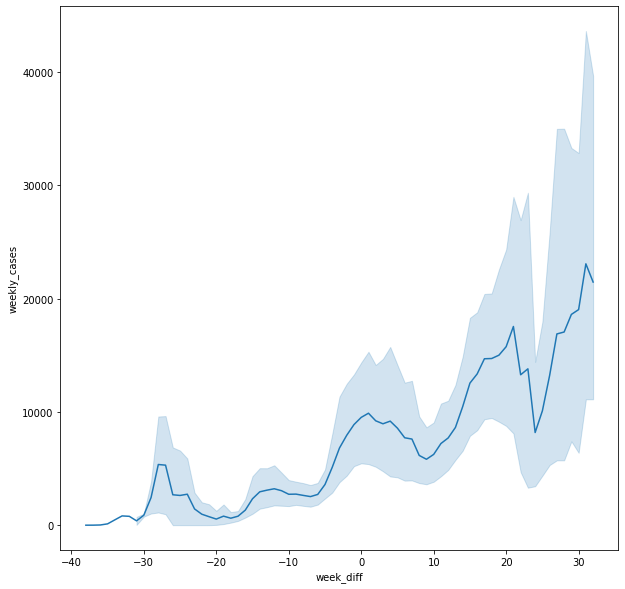

In [19]:
#Create a graph that shows the variation of cases 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.lineplot(x=cases.loc[cases.mandate_week!=0,'week_diff'], y=y, data=cases, )